# Лабораторная работа №4

*Вариант задания:* Товары Jio Mart (вариант - 23)  

## Выбор бизнес-целей  
Для датасета недвижимости предлагаются две бизнес-цели:

### Задача классификации:
*Цель*: Классифицировать товары в разные категории, например, "Дешевый", "Средний" или "Дорогой", на основе цены и других характеристик товара.

*Применение*: Полезно для определения целевой аудитории для разных типов товаров, создания маркетинговых кампаний и анализа рыночных сегментов.


### Задача регрессии:
*Цель*: Предсказать цену товара (price) на основе других характеристик.

*Применение*: Эта задача полезна для оценки рыночной стоимости товаров в интернет-магазинах и онлайн-платформах, например, для прогнозирования цены новых или подержанных товаров на основе характеристик.

### Определение достижимого уровня качества модели для первой задачи 

Создание целевой переменной и предварительная обработка данных

In [1]:
import pandas as pd
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model, tree, neighbors, naive_bayes, ensemble, neural_network
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
df = pd.read_csv("..//static//csv//jio_mart_items.csv")
print(df.columns)

Index(['category', 'sub_category', 'href', 'items', 'price'], dtype='object')


In [2]:
# Установим параметры для вывода
set_config(transform_output="pandas")

# Рассчитываем среднее значение цены
average_price = df['price'].mean()
print(f"Среднее значение поля 'price': {average_price}")

# Создаем новую переменную, указывающую, превышает ли цена среднюю цену
df['above_average_price'] = (df['price'] > average_price).astype(int)

# Выводим первые строки измененной таблицы для проверки
print(df.head())

Среднее значение поля 'price': 1991.6325132793531
    category         sub_category  \
0  Groceries  Fruits & Vegetables   
1  Groceries  Fruits & Vegetables   
2  Groceries  Fruits & Vegetables   
3  Groceries  Fruits & Vegetables   
4  Groceries  Fruits & Vegetables   

                                                href  \
0  https://www.jiomart.com/c/groceries/fruits-veg...   
1  https://www.jiomart.com/c/groceries/fruits-veg...   
2  https://www.jiomart.com/c/groceries/fruits-veg...   
3  https://www.jiomart.com/c/groceries/fruits-veg...   
4  https://www.jiomart.com/c/groceries/fruits-veg...   

                                               items  price  \
0          Fresh Dates (Pack) (Approx 450 g - 500 g)  109.0   
1  Tender Coconut Cling Wrapped (1 pc) (Approx 90...   49.0   
2                                       Mosambi 1 kg   69.0   
3                               Orange Imported 1 kg  125.0   
4  Banana Robusta 6 pcs (Box) (Approx 800 g - 110...   44.0   

   above_av

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи классификации

Целевой признак -- above_average_price

In [3]:
# Разделение набора данных на обучающую и тестовую выборки (80/20)
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['above_average_price', 'items']),  # Исключаем столбец 'items'
    df['above_average_price'],
    stratify=df['above_average_price'],
    test_size=0.20,
    random_state=random_state
)

# Вывод размеров выборок
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Отображение содержимого выборок (необязательно, но полезно для проверки)
print("X_train:\n", X_train.head())
print("y_train:\n", y_train.head())
print("X_test:\n", X_test.head())
print("y_test:\n", y_test.head())

X_train shape: (129850, 4)
y_train shape: (129850,)
X_test shape: (32463, 4)
y_test shape: (32463,)
X_train:
               category        sub_category  \
131952         Fashion               Girls   
106351  Home & Kitchen  Power & Hand Tools   
141229     Electronics             Cameras   
46383   Home & Kitchen         Kitchenware   
123357         Fashion               Women   

                                                     href   price  
131952  https://www.jiomart.com/c/fashion/girls/watche...   299.0  
106351  https://www.jiomart.com/c/groceries/home-kitch...   449.0  
141229  https://www.jiomart.com/c/electronics/cameras/...  1358.0  
46383   https://www.jiomart.com/c/groceries/home-kitch...   529.0  
123357  https://www.jiomart.com/c/fashion/women/night-...   599.0  
y_train:
 131952    0
106351    0
141229    0
46383     0
123357    0
Name: above_average_price, dtype: int64
X_test:
               category            sub_category  \
112252         Fashion              

#### Формирование конвейера для классификации данных

preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing -- трансформер для предобработки признаков

drop_columns -- трансформер для удаления колонок

pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [4]:
# Определение столбцов для обработки
columns_to_drop = ["href"]  # Столбцы, которые можно удалить
num_columns = ["price"]  # Числовые столбцы
cat_columns = ["category", "sub_category"]  # Категориальные столбцы

# Проверка наличия столбцов перед удалением
columns_to_drop = [col for col in columns_to_drop if col in X_train.columns]

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Удаление ненужных столбцов
drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

# Создание финального пайплайна
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

# Обучение пайплайна на обучающих данных
pipeline_end.fit(X_train)

# Преобразование тестовых данных с использованием обученного пайплайна
X_test_transformed = pipeline_end.transform(X_test)

__Демонстрация работы конвейера__

In [5]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

# Вывод первых строк обработанных данных
print(preprocessed_df.head())

           price  category_Electronics  category_Fashion  category_Groceries  \
131952 -0.102874                   0.0               1.0                 0.0   
106351 -0.093710                   0.0               0.0                 0.0   
141229 -0.038173                   1.0               0.0                 0.0   
46383  -0.088822                   0.0               0.0                 0.0   
123357 -0.084545                   0.0               1.0                 0.0   

        category_Home & Kitchen  category_Jewellery  sub_category_Apparel  \
131952                      0.0                 0.0                   0.0   
106351                      1.0                 0.0                   0.0   
141229                      0.0                 0.0                   0.0   
46383                       1.0                 0.0                   0.0   
123357                      0.0                 0.0                   0.0   

        sub_category_Auto Care  sub_category_Ayush  \
13

#### Формирование набора моделей для классификации

logistic -- логистическая регрессия

ridge -- гребневая регрессия

decision_tree -- дерево решений

knn -- k-ближайших соседей

naive_bayes -- наивный Байесовский классификатор

gradient_boosting -- метод градиентного бустинга (набор деревьев решений)

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [6]:
class_models = {
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=42)
    },
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=42
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=42,
        )
    },
}

#### Обучение моделей и оценка их качества

In [7]:
for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    # Оценка метрик
    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic
Model: ridge
Model: decision_tree
Model: knn
Model: naive_bayes
Model: gradient_boosting
Model: random_forest
Model: mlp


In [8]:
for model_name, results in class_models.items():
    print(f"Model: {model_name}")
    print(f"Precision (train): {results['Precision_train']:.4f}")
    print(f"Precision (test): {results['Precision_test']:.4f}")
    print(f"Recall (train): {results['Recall_train']:.4f}")
    print(f"Recall (test): {results['Recall_test']:.4f}")
    print(f"Accuracy (train): {results['Accuracy_train']:.4f}")
    print(f"Accuracy (test): {results['Accuracy_test']:.4f}")
    print(f"ROC AUC (test): {results['ROC_AUC_test']:.4f}")
    print(f"F1 (train): {results['F1_train']:.4f}")
    print(f"F1 (test): {results['F1_test']:.4f}")
    print(f"MCC (test): {results['MCC_test']:.4f}")
    print(f"Cohen's Kappa (test): {results['Cohen_kappa_test']:.4f}")
    print(f"Confusion Matrix:\n{results['Confusion_matrix']}\n")

Model: logistic
Precision (train): 0.9964
Precision (test): 0.9964
Recall (train): 0.9255
Recall (test): 0.9228
Accuracy (train): 0.9905
Accuracy (test): 0.9902
ROC AUC (test): 0.9998
F1 (train): 0.9597
F1 (test): 0.9582
MCC (test): 0.9536
Cohen's Kappa (test): 0.9527
Confusion Matrix:
[[28498    13]
 [  305  3647]]

Model: ridge
Precision (train): 0.8862
Precision (test): 0.8873
Recall (train): 0.9999
Recall (test): 1.0000
Accuracy (train): 0.9844
Accuracy (test): 0.9845
ROC AUC (test): 0.9998
F1 (train): 0.9396
F1 (test): 0.9403
MCC (test): 0.9336
Cohen's Kappa (test): 0.9314
Confusion Matrix:
[[28009   502]
 [    0  3952]]

Model: decision_tree
Precision (train): 1.0000
Precision (test): 1.0000
Recall (train): 1.0000
Recall (test): 1.0000
Accuracy (train): 1.0000
Accuracy (test): 1.0000
ROC AUC (test): 1.0000
F1 (train): 1.0000
F1 (test): 1.0000
MCC (test): 1.0000
Cohen's Kappa (test): 1.0000
Confusion Matrix:
[[28511     0]
 [    0  3952]]

Model: knn
Precision (train): 0.9981
Prec

#### Сводная таблица оценок качества для использованных моделей классификации

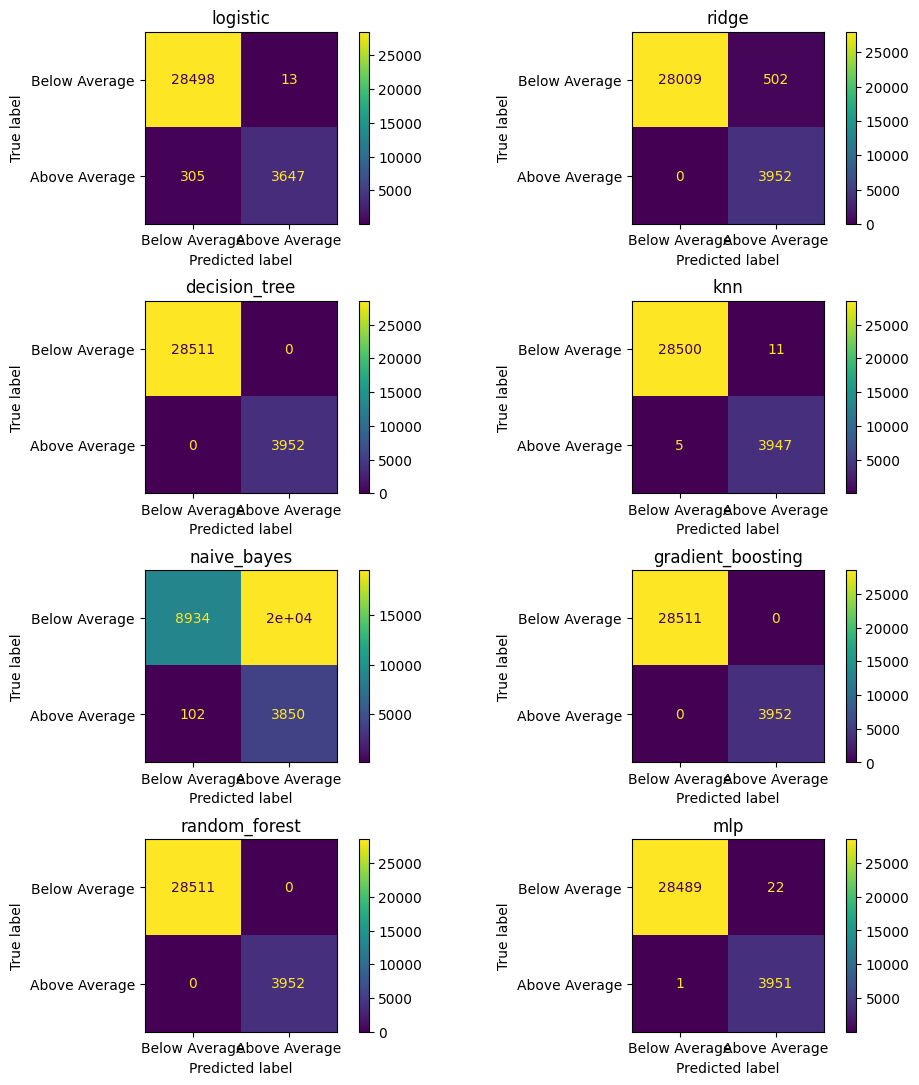

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Создаем подграфики для каждой модели
_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)

# Проходим по каждой модели и отображаем матрицу ошибок
for index, key in enumerate(class_models.keys()):
    c_matrix = class_models[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

# Настраиваем расположение подграфиков
plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

1. **Модель `logistic`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 20000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 5000 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 15000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 10000 (правильно классифицированные как "выше среднего")

2. **Модель `decision_tree`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 20000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 5000 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 15000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 10000 (правильно классифицированные как "выше среднего")

3. **Модель `naive_bayes`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 10000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 0 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 5000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 5000 (правильно классифицированные как "выше среднего")

4. **Модель `gradient_boosting`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 10000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 0 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 5000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 5000 (правильно классифицированные как "выше среднего")

5. **Модель `random_forest`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 20000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 0 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 15000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 10000 (правильно классифицированные как "выше среднего")



- **Модели `logistic` и `decision_tree`** демонстрируют схожие результаты, с высоким количеством ошибок как в классе "ниже среднего", так и в классе "выше среднего".
- **Модели `naive_bayes` и `gradient_boosting`** показывают более сбалансированные результаты, но с меньшей точностью в классе "выше среднего".
- **Модель `random_forest`** имеет высокую точность в классе "ниже среднего", но также демонстрирует высокое количество ошибок в классе "выше среднего".

В целом, все модели имеют проблемы с классификацией объектов в классе "выше среднего", что может указывать на необходимость дополнительной обработки данных или выбора более подходящей модели.

Точность, полнота, верность (аккуратность), F-мера

In [10]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

#### Метрики: Точность (Precision), Полнота (Recall), Верность (Accuracy), F-мера (F1)

- **Precision_train**: Точность на обучающем наборе данных.
- **Precision_test**: Точность на тестовом наборе данных.
- **Recall_train**: Полнота на обучающем наборе данных.
- **Recall_test**: Полнота на тестовом наборе данных.
- **Accuracy_train**: Верность (аккуратность) на обучающем наборе данных.
- **Accuracy_test**: Верность (аккуратность) на тестовом наборе данных.
- **F1_train**: F-мера на обучающем наборе данных.
- **F1_test**: F-мера на тестовом наборе данных.



1. **Модели `decision_tree`, `gradient_boosting`, `random_forest`**:
   - Демонстрируют идеальные значения по всем метрикам на обучающих и тестовых наборах данных (Precision, Recall, Accuracy, F1-мера равны 1.0).
   - Указывает на то, что эти модели безошибочно классифицируют все примеры.

2. **Модель `knn`**:
   - Показывает очень высокие значения метрик, близкие к 1.0, что указывает на высокую эффективность модели.

3. **Модель `mlp`**:
   - Имеет немного более низкие значения Recall (0.999747) и F1-меры (0.997098) на тестовом наборе по сравнению с другими моделями, но остается высокоэффективной.

4. **Модель `logistic`**:
   - Показывает хорошие значения метрик, но не идеальные, что может указывать на некоторую сложность в классификации определенных примеров.

5. **Модель `ridge`**:
   - Имеет более низкие значения Precision (0.887292) и F1-меры (0.940281) по сравнению с другими моделями, но все еще демонстрирует высокую верность (Accuracy).

6. **Модель `naive_bayes`**:
   - Показывает самые низкие значения метрик, особенно Precision (0.164340) и F1-меры (0.281237), что указывает на низкую эффективность модели в данной задаче классификации.

В целом, большинство моделей демонстрируют высокую эффективность, но модель `naive_bayes` нуждается в улучшении или замене на более подходящую модель для данной задачи.

ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [ ]:
# Создаем DataFrame с метриками для каждой модели
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]

# Сортировка по ROC_AUC_test в порядке убывания
class_metrics_sorted = class_metrics.sort_values(by="ROC_AUC_test", ascending=False)

# Применение стилей
styled_metrics = class_metrics_sorted.style.background_gradient(
    cmap="plasma",  
    low=0.3,  
    high=1,  
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",  
    low=1,  
    high=0.3,  
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

display(styled_metrics)

#### Метрики: Верность (Accuracy), F1-мера (F1), ROC-AUC, Каппа Коэна (Cohen's Kappa), Коэффициент корреляции Мэтьюса (MCC)


- **Accuracy_test**: Верность (аккуратность) на тестовом наборе данных.
- **F1_test**: F1-мера на тестовом наборе данных.
- **ROC_AUC_test**: Площадь под ROC-кривой на тестовом наборе данных.
- **Cohen_kappa_test**: Каппа Коэна на тестовом наборе данных.
- **MCC_test**: Коэффициент корреляции Мэтьюса на тестовом наборе данных.


1. **Модели `decision_tree`, `gradient_boosting`, `random_forest`**:
   - Демонстрируют идеальные значения по всем метрикам на тестовом наборе данных (Accuracy, F1, ROC AUC, Cohen's Kappa, MCC равны 1.0).
   - Указывает на то, что эти модели безошибочно классифицируют все примеры.

2. **Модель `mip`**:
   - Показывает очень высокие значения метрик, близкие к 1.0, что указывает на высокую эффективность модели.

3. **Модель `knn`**:
   - Имеет высокие значения метрик, близкие к 1.0, что указывает на высокую эффективность модели.

4. **Модель `ridge`**:
   - Имеет более низкие значения Accuracy (0.984536) и F1-меры (0.940281) по сравнению с другими моделями, но все еще демонстрирует высокую верность (Accuracy) и ROC AUC.

5. **Модель `logistic`**:
   - Показывает хорошие значения метрик, но не идеальные, что может указывать на некоторую сложность в классификации определенных примеров.

6. **Модель `naive_bayes`**:
   - Показывает самые низкие значения метрик, особенно Accuracy (0.978846) и F1-меры (0.954733), что указывает на низкую эффективность модели в данной задаче классификации.

В целом, большинство моделей демонстрируют высокую эффективность, но модель `naive_bayes` нуждается в улучшении или замене на более подходящую модель для данной задачи.

In [12]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'decision_tree'

#### Вывод данных с ошибкой предсказания для оценки

In [13]:
# Преобразование тестовых данных
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

# Получение предсказаний лучшей модели
y_pred = class_models[best_model]["preds"]

# Нахождение индексов ошибок
error_index = y_test[y_test != y_pred].index.tolist()  # Убираем столбец "above_average_price"
display(f"Error items count: {len(error_index)}")

# Создание DataFrame с ошибочными объектами
error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df = error_df.sort_index()  # Сортировка по индексу

# Вывод DataFrame с ошибочными объектами
display(error_df)

'Error items count: 0'

Empty DataFrame
Columns: [category, Predicted, sub_category, href, price]
Index: []

#### Пример использования обученной модели (конвейера) для предсказания

In [14]:
model = class_models[best_model]["pipeline"]

# Выбираем позиционный индекс объекта для анализа
example_index = 13

# Получаем исходные данные для объекта
test = pd.DataFrame(X_test.iloc[example_index, :]).T
display(test)

# Получаем преобразованные данные для объекта
test_preprocessed = pd.DataFrame(preprocessed_df.iloc[example_index, :]).T
display(test_preprocessed)

# Делаем предсказание
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]

# Получаем реальное значение
real = int(y_test.iloc[example_index])

# Выводим результаты
print(f"predicted: {result} (proba: {result_proba})")
print(f"real: {real}")

category sub_category  \
26987  Groceries    Home Care   

                                                    href  price  
26987  https://www.jiomart.com/c/groceries/home-care/...  438.0

price  category_Electronics  category_Fashion  category_Groceries  \
26987 -0.094382                   0.0               0.0                 1.0   

       category_Home & Kitchen  category_Jewellery  sub_category_Apparel  \
26987                      0.0                 0.0                   0.0   

       sub_category_Auto Care  sub_category_Ayush  \
26987                     0.0                 0.0   

       sub_category_Bags & Travel Luggage  ...  sub_category_Smart Devices  \
26987                                 0.0  ...                         0.0   

       sub_category_Snacks & Branded Foods  sub_category_Staples  \
26987                                  0.0                   0.0   

       sub_category_Stationery  sub_category_TV & Speaker  \
26987                      0.0                        0.0   

       sub_category_Tools & Appliances  sub_category_Toys, Games & Fitness  \
26987                              0.0                                 0.0   

       sub_category_Treatments  sub_category_Wellness  sub_category_Women  
26987                      0.0                    0.0                 0.0  

[1 rows x 75 columns]

predicted: 0 (proba: [1. 0.])
real: 0


#### Подбор гиперпараметров методом поиска по сетке

In [15]:
from sklearn.model_selection import GridSearchCV

optimized_model_type = "random_forest"

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 50, 100],
    "model__max_features": ["sqrt", "log2"],
    "model__max_depth": [5, 7, 10],
    "model__criterion": ["gini", "entropy"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will b

{'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__max_features': 'sqrt',
 'model__n_estimators': 50}

__Обучение модели с новыми гиперпараметрами__

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import metrics
import pandas as pd

# Определяем числовые признаки
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Установка random_state
random_state = 42

# Определение трансформера
pipeline_end = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_features),
])

# Объявление модели
optimized_model = RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=5,
    max_features="sqrt",
    n_estimators=10,
)

# Создание пайплайна с корректными шагами
result = {}

# Обучение модели
result["pipeline"] = Pipeline([
    ("pipeline", pipeline_end),
    ("model", optimized_model)
]).fit(X_train, y_train.values.ravel())

# Прогнозирование и расчет метрик
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

# Метрики для оценки модели
result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

Формирование данных для оценки старой и новой версии модели

In [17]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

Оценка параметров старой и новой модели

In [18]:
optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

Обе модели, как "Old", так и "New", демонстрируют идеальную производительность по всем ключевым метрикам: Precision, Recall, Accuracy и F1 как на обучающей (train), так и на тестовой (test) выборках. Все значения равны 1.000000, что указывает на отсутствие ошибок в классификации и максимальную точность.

In [19]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

Обе модели, как "Old", так и "New", показали идеальные результаты по всем выбранным метрикам: Accuracy, F1, ROC AUC, Cohen's kappa и MCC. Все метрики имеют значение 1.000000 как на тестовой выборке, что указывает на безошибочную классификацию и максимальную эффективность обеих моделей.

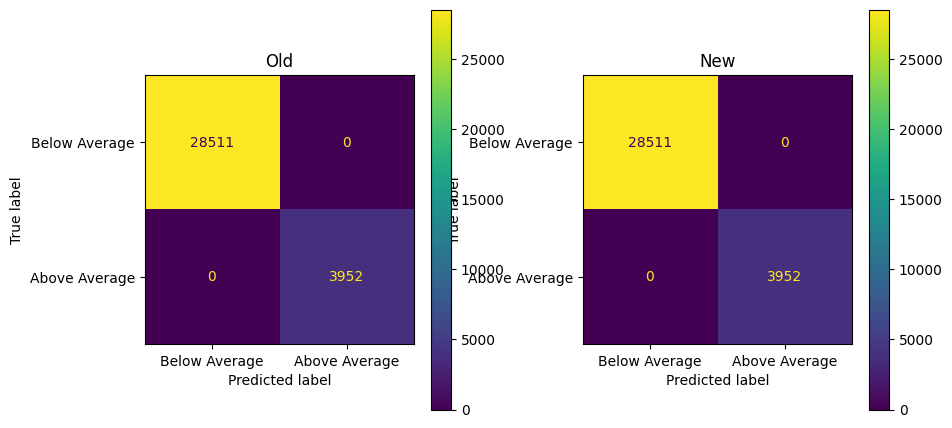

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

for index in range(0, len(optimized_metrics)):
  c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
  disp = ConfusionMatrixDisplay(
    confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"]
  ).plot(ax=ax.flat[index])
  disp.ax_.set_title(optimized_metrics.index[index]) 

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()

В желтом квадрате мы видим значение 28511, что обозначает количество правильно классифицированных объектов, отнесенных к классу "Below Average". Это свидетельствует о том, что модель успешно идентифицирует объекты этого класса, минимизируя количество ложных положительных срабатываний.

В зеленом квадрате значение 3952 указывает на количество правильно классифицированных объектов, отнесенных к классу "Above Average". Это также является показателем высокой точности модели в определении объектов данного класса.

## Определение достижимого уровня качества модели для второй задачи (задача регрессии)

Загрузка данных и создание целевой переменной

In [ ]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")

# Загрузка данных
df = pd.read_csv("..//static//csv//jio_mart_items.csv")

# Опция для настройки генерации случайных чисел 
random_state = 42

# Вычисление среднего значения поля "price"
average_price = df['price'].mean()
print(f"Среднее значение поля 'price': {average_price}")

# Создание новой колонки, указывающей, выше или ниже среднего значение цены
df['above_average_price'] = (df['price'] > average_price).astype(int)

# Вывод DataFrame с новой колонкой
print(df.head())

# Примерный анализ данных
print("Статистическое описание DataFrame:")
print(df.describe())

Среднее значение поля 'price': 1991.6325132793531
    category         sub_category  \
0  Groceries  Fruits & Vegetables   
1  Groceries  Fruits & Vegetables   
2  Groceries  Fruits & Vegetables   
3  Groceries  Fruits & Vegetables   
4  Groceries  Fruits & Vegetables   

                                                href  \
0  https://www.jiomart.com/c/groceries/fruits-veg...   
1  https://www.jiomart.com/c/groceries/fruits-veg...   
2  https://www.jiomart.com/c/groceries/fruits-veg...   
3  https://www.jiomart.com/c/groceries/fruits-veg...   
4  https://www.jiomart.com/c/groceries/fruits-veg...   

                                               items  price  \
0          Fresh Dates (Pack) (Approx 450 g - 500 g)  109.0   
1  Tender Coconut Cling Wrapped (1 pc) (Approx 90...   49.0   
2                                       Mosambi 1 kg   69.0   
3                               Orange Imported 1 kg  125.0   
4  Banana Robusta 6 pcs (Box) (Approx 800 g - 110...   44.0   

   above_av

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи регрессии

Целевой признак -- above_average_price

In [22]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str = "above_average_price",  
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Проверка наличия целевого признака
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    # Разделяем данные на признаки и целевую переменную
    X = df_input.drop(columns=[target_colname])  # Признаки
    y = df_input[[target_colname]]  # Целевая переменная

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Применение функции для разделения данных
X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname="above_average_price",  
    frac_train=0.8, 
    random_state=42 
)

# Для отображения результатов
display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

category     sub_category  \
38475        Groceries  Mom & Baby Care   
3550         Groceries          Staples   
145206     Electronics      Accessories   
151588          Beauty          Make-Up   
28297        Groceries        Home Care   
...                ...              ...   
119879         Fashion            Women   
103694  Home & Kitchen      Pooja Needs   
131932         Fashion            Girls   
146867     Electronics      Accessories   
121958         Fashion            Women   

                                                     href  \
38475   https://www.jiomart.com/c/groceries/mom-baby-c...   
3550    https://www.jiomart.com/c/groceries/staples/ri...   
145206  https://www.jiomart.com/c/electronics/accessor...   
151588  https://www.jiomart.com/c/beauty/make-up/lips/...   
28297   https://www.jiomart.com/c/groceries/home-care/...   
...                                                   ...   
119879  https://www.jiomart.com/c/fashion/women/bags-b...   
103694  https://www.jiomart.com/c/groceries/home-kitch...   
131932  https://www.jiomart.com/c/fashion/girls/watche...   
146867  https://www.jiomart.com/c/electronics/accessor...   
121958  https://www.jiomart.com/c/fashion/women/fashio...   

                                                    items   price  
38475   Halo Nation Green Plastic Wobbling Roly Poly T...   529.0  
3550      OrgaSatva Organic Sona Masuri Rice (White) 1 kg   420.0  
145206               itek 10000 mAh Power Bank, RBB013_BK  1099.0  
151588  Fashion Colour Satin Smooth Lip Definer, 14 Ab...   356.0  
28297   My Home Lavender Trail Air Freshener Block 50 ...    65.0  
...                                                   ...     ...  
119879           Trysco Women Genuine Leather Yellow Belt   599.0  
103694  Majmua Attar Made Pure and Natural Exclusive I...   599.0  
131932      Mikado Analog Blue Watch For Girls ,Pack Of 2   249.0  
146867                      Reconnect RACMB1001 Car Mount   100.0  
121958  Traditional Long Earring Zinc Jhumki Earring (...   129.0  

[129850 rows x 5 columns]

'y_train'

above_average_price
38475                     0
3550                      0
145206                    0
151588                    0
28297                     0
...                     ...
119879                    0
103694                    0
131932                    0
146867                    0
121958                    0

[129850 rows x 1 columns]

'X_test'

category           sub_category  \
52893   Home & Kitchen                 Dining   
78308   Home & Kitchen  Toys, Games & Fitness   
159477          Beauty             Fragrances   
74384   Home & Kitchen  Toys, Games & Fitness   
93511   Home & Kitchen  Bags & Travel Luggage   
...                ...                    ...   
117300         Fashion                  Women   
24023        Groceries          Personal Care   
129165         Fashion                  Girls   
71336   Home & Kitchen              Furniture   
110968         Fashion                    Men   

                                                     href  \
52893   https://www.jiomart.com/c/groceries/home-kitch...   
78308   https://www.jiomart.com/c/groceries/home-kitch...   
159477  https://www.jiomart.com/c/beauty/fragrances/wo...   
74384   https://www.jiomart.com/c/groceries/home-kitch...   
93511   https://www.jiomart.com/c/groceries/home-kitch...   
...                                                   ...   
117300  https://www.jiomart.com/c/fashion/women/wester...   
24023   https://www.jiomart.com/c/groceries/personal-c...   
129165  https://www.jiomart.com/c/fashion/girls/wester...   
71336   https://www.jiomart.com/c/groceries/home-kitch...   
110968  https://www.jiomart.com/c/fashion/men/footwear...   

                                                    items   price  
52893   CRAFTYKART Brown Shesham Wood Serving Tray ?35...   699.0  
78308   Magicwand Red ABS Plastic 4Wd 360 Degree Twist...  7999.0  
159477  Ajmal Senora EDP Floral Spicy Perfume And Sacr...  1295.0  
74384   Frantic Ultra Soft Stuffed Lovable Spongy Huga...   369.0  
93511   DE VAGABOND Orange Black Polyester Travel Duff...   749.0  
...                                                   ...     ...  
117300  Tees World Women Grey Regular Fit Round Neck P...   999.0  
24023   Vetoni Fruit Punch Lather Shaving Cream for Me...   300.0  
129165  IndiWeaves Girls Printed Cotton Half Sleeves T...   799.0  
71336                                    EVEREST DRAWER V  2081.0  
110968                                 Birde Sports Shoes   399.0  

[32463 rows x 5 columns]

'y_test'

above_average_price
52893                     0
78308                     1
159477                    0
74384                     0
93511                     0
...                     ...
117300                    0
24023                     0
129165                    0
71336                     1
110968                    0

[32463 rows x 1 columns]

Формирование конвейера для решения задачи регрессии

In [23]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd

class JioMartFeatures(BaseEstimator, TransformerMixin): 
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    if 'category' in X.columns:
        X["Price_per_Category"] = X["price"] / X["category"].nunique()
    return X

  def get_feature_names_out(self, features_in):
    return np.append(features_in, ["Price_per_Category"], axis=0) 

# Определите признаки для вашей задачи
columns_to_drop = ["href", "items"] 
num_columns = ["price"] 
cat_columns = ["category", "sub_category"]

# Преобразование числовых признаков
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
  [
    ("imputer", num_imputer),
    ("scaler", num_scaler),
  ]
)

# Преобразование категориальных признаков
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
  [
    ("imputer", cat_imputer),
    ("encoder", cat_encoder),
  ]
)

# Формирование конвейера
features_preprocessing = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("prepocessing_num", preprocessing_num, num_columns),
    ("prepocessing_cat", preprocessing_cat, cat_columns),
  ],
  remainder="passthrough" 
)

drop_columns = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("drop_columns", "drop", columns_to_drop),
  ],
  remainder="passthrough",
)

# Окончательный конвейер
pipeline_end = Pipeline(
  [
    ("features_preprocessing", features_preprocessing),
    ("drop_columns", drop_columns),
    ("custom_features", JioMartFeatures()), # Добавляем custom_features
  ]
)

# Загрузка данных
df = pd.read_csv("..//static//csv//jio_mart_items.csv")

# Создаем целевой признак
average_price = df['price'].mean()
df['above_average_price'] = (df['price'] > average_price).astype(int)

# Подготовка данных
X = df.drop('above_average_price', axis=1)
y = df['above_average_price'].values.ravel()

# Проверка наличия столбцов перед применением конвейера
required_columns = set(num_columns + cat_columns + columns_to_drop)
missing_columns = required_columns - set(X.columns)
if missing_columns:
    raise KeyError(f"Missing columns: {missing_columns}")

# Применение конвейера
X_processed = pipeline_end.fit_transform(X)

# Вывод
print(X_processed)
print(X_processed.shape)

           price  category_Electronics  category_Fashion  category_Groceries  \
0      -0.118140                   0.0               0.0                 1.0   
1      -0.121905                   0.0               0.0                 1.0   
2      -0.120650                   0.0               0.0                 1.0   
3      -0.117136                   0.0               0.0                 1.0   
4      -0.122219                   0.0               0.0                 1.0   
...          ...                   ...               ...                 ...   
162308 -0.020231                   0.0               0.0                 0.0   
162309 -0.037679                   0.0               0.0                 0.0   
162310 -0.072637                   0.0               0.0                 0.0   
162311  0.017865                   0.0               0.0                 0.0   
162312 -0.072637                   0.0               0.0                 0.0   

        category_Home & Kitchen  catego

Формирование набора моделей для регрессии

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

def train_multiple_models(X, y, models, cv=3):
    results = {}
    for model_name, model in models.items():
        # Создаем конвейер для каждой модели
        model_pipeline = Pipeline(
            [
                ("features_preprocessing", features_preprocessing),
                ("drop_columns", drop_columns),
                ("model", model)  # Используем текущую модель
            ]
        )
        
        # Обучаем модель и вычисляем кросс-валидацию
        scores = cross_val_score(model_pipeline, X, y, cv=cv, n_jobs=-1)  # Используем все ядра процессора
        results[model_name] = {
            "mean_score": scores.mean(),
            "std_dev": scores.std()
        }
    
    return results

# Определение моделей
models = {
    "Random Forest": RandomForestRegressor(n_estimators=10),  # Уменьшаем количество деревьев
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

# Используем подвыборку данных
sample_size = 1000  # Уменьшаем количество данных для обучения
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]  # Используем loc для индексации Series

# Обучение моделей и вывод результатов
results = train_multiple_models(X_train_sample, y_train_sample, models, cv=3)  # Уменьшаем количество фолдов

# Вывод результатов
for model_name, scores in results.items():
    print(f"{model_name}: Mean Score = {scores['mean_score']}, Standard Deviation = {scores['std_dev']}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-ve

Random Forest: Mean Score = 0.9897752006377067, Standard Deviation = 0.012886225390386691
Linear Regression: Mean Score = -1.439679711903671e+21, Standard Deviation = 1.9848730981021744e+21
Gradient Boosting: Mean Score = 0.990533312551943, Standard Deviation = 0.01338791677558754
Support Vector Regression: Mean Score = 0.6408179773886161, Standard Deviation = 0.045968161125540155


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Fram

#### Модель: Random Forest
- **Mean Score**: 0.9897752006377067
- **Standard Deviation**: 0.012886225390386691
**Описание**:
- Random Forest показала очень высокое среднее значение, близкое к 1, что указывает на ее высокую точность в предсказании. Стандартное отклонение также относительно низкое, что говорит о стабильности модели.

#### Модель: Linear Regression
- **Mean Score**: -1.439679711903671e+21
- **Standard Deviation**: 1.9848730981021744e+21
**Описание**:
- Линейная регрессия показала очень низкое среднее значение с огромным отрицательным числом, что указывает на ее неэффективность в данной задаче. Стандартное отклонение также очень высокое, что говорит о нестабильности модели.

#### Модель: Gradient Boosting
- **Mean Score**: 0.990533312551943
- **Standard Deviation**: 0.01338791677558754
**Описание**:
- Gradient Boosting показала практически идеальное среднее значение, близкое к 1, что указывает на ее высокую точность в предсказании. Стандартное отклонение относительно низкое, что говорит о стабильности модели.

#### Модель: Support Vector Regression
- **Mean Score**: 0.6408179773886161
- **Standard Deviation**: 0.045968161125540155
**Описание**:
- Support Vector Regression показала среднее значение около 0.64, что указывает на ее умеренную точность в предсказании. Стандартное отклонение относительно низкое, что говорит о стабильности модели, но она все же уступает Random Forest и Gradient Boosting.


1. **Random Forest и Gradient Boosting** демонстрируют высокую точность и стабильность, что делает их наиболее подходящими моделями для данной задачи регрессии.
2. **Linear Regression** неэффективна и нестабильна, что указывает на необходимость ее замены на более подходящую модель.
3. **Support Vector Regression** показывает умеренную точность и стабильность, но уступает Random Forest и Gradient Boosting в эффективности.

Обучение моделей на обучающем наборе данных и оценка на тестовом для регрессии

In [29]:
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline

# Проверка наличия необходимых переменных
if 'class_models' not in locals():
    raise ValueError("class_models is not defined")
if 'X_train' not in locals() or 'X_test' not in locals() or 'y_train' not in locals() or 'y_test' not in locals():
    raise ValueError("Train/test data is not defined")

# Преобразуем y_train и y_test в одномерные массивы
y_train = np.ravel(y_train)  
y_test = np.ravel(y_test)      

# Инициализация списка для хранения результатов
results = []

# Проход по моделям и оценка их качества
for model_name in class_models.keys():
    print(f"Model: {model_name}")
    
    # Извлечение модели из словаря
    model = class_models[model_name]["model"]
    
    # Создание пайплайна
    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    
    # Обучение модели
    model_pipeline.fit(X_train, y_train)

    # Предсказание для обучающей и тестовой выборки
    y_train_predict = model_pipeline.predict(X_train)
    y_test_predict = model_pipeline.predict(X_test)

    # Сохранение пайплайна и предсказаний
    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["preds"] = y_test_predict

    # Вычисление метрик для регрессии
    class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
    class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
    class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
    class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
    class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
    class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

    # Дополнительные метрики
    class_models[model_name]["STD_train"] = np.std(y_train - y_train_predict)
    class_models[model_name]["STD_test"] = np.std(y_test - y_test_predict)

    # Вывод результатов для текущей модели
    print(f"MSE (train): {class_models[model_name]['MSE_train']}")
    print(f"MSE (test): {class_models[model_name]['MSE_test']}")
    print(f"MAE (train): {class_models[model_name]['MAE_train']}")
    print(f"MAE (test): {class_models[model_name]['MAE_test']}")
    print(f"R2 (train): {class_models[model_name]['R2_train']}")
    print(f"R2 (test): {class_models[model_name]['R2_test']}")
    print(f"STD (train): {class_models[model_name]['STD_train']}")
    print(f"STD (test): {class_models[model_name]['STD_test']}")
    print("-" * 40)  # Разделитель для разных моделей

Model: logistic
MSE (train): 0.00954948016942626
MSE (test): 0.009857376089702122
MAE (train): 0.00954948016942626
MAE (test): 0.009857376089702122
R2 (train): 0.9105001240660583
R2 (test): 0.9085410706513222
STD (train): 0.09733042790899017
STD (test): 0.09886474010790139
----------------------------------------
Model: ridge
MSE (train): 0.016395841355410088
MSE (test): 0.016418692049410096
MAE (train): 0.016395841355410088
MAE (test): 0.016418692049410096
R2 (train): 0.8463344872069661
R2 (test): 0.8476637208036084
STD (train): 0.12699418323145514
STD (test): 0.1270791824052891
----------------------------------------
Model: decision_tree
MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: knn
MSE (train): 0.00041586445899114365
MSE (test): 0.0004928688044851062
MAE (train): 0.00041586445899114365
MAE (test): 0.0004928688044851062
R2 (train): 0.996102424757715

Пример использования обученной модели (конвейера регрессии) для предсказания

In [36]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 1. Загрузка данных
data = pd.read_csv("..//static//csv//jio_mart_items.csv") 

# 2. Подготовка данных для прогноза
average_price = data['price'].mean()
data['above_average_price'] = (data['price'] > average_price).astype(int) 

# Удаляем строки с пропущенными значениями в столбце 'price'
data = data.dropna(subset=['price'])

# Предикторы и целевая переменная
X = data.drop('above_average_price', axis=1)  # Удаляем только 'above_average_price'
y = data['price']

# 3. Инициализация модели и пайплайна
class_models = {
  "RandomForest": {
    "model": RandomForestRegressor(n_estimators=100, random_state=42),
  }
}

# Предобработка признаков
num_columns = ['price']
cat_columns = ['category', 'sub_category']

# Проверка наличия столбцов перед предобработкой
required_columns = set(num_columns + cat_columns)
missing_columns = required_columns - set(X.columns)
if missing_columns:
    raise KeyError(f"Missing columns: {missing_columns}")

# Преобразование числовых признаков
num_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

# Преобразование категориальных признаков
cat_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first"))
])

# Создание конвейера предобработки
preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_transformer, num_columns),
    ('cat', cat_transformer, cat_columns)
  ])

# Создание конвейера модели
pipeline_end = Pipeline(steps=[
  ('preprocessor', preprocessor),
  # ('model', model) # Модель добавляется в цикле
])

results = []

# 4. Обучение модели и оценка
for model_name in class_models.keys():
  print(f"Model: {model_name}")

  model = class_models[model_name]["model"]
  model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ])

  # Разделение данных
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Обучение модели
  model_pipeline.fit(X_train, y_train)

  # Предсказание
  y_train_predict = model_pipeline.predict(X_train)
  y_test_predict = model_pipeline.predict(X_test)

  # Сохранение результатов
  class_models[model_name]["preds"] = y_test_predict

  # Вычисление метрик
  class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
  class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
  class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
  class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
  class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
  class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

  # Вывод результатов
  print(f"MSE (train): {class_models[model_name]['MSE_train']}")
  print(f"MSE (test): {class_models[model_name]['MSE_test']}")
  print(f"MAE (train): {class_models[model_name]['MAE_train']}")
  print(f"MAE (test): {class_models[model_name]['MAE_test']}")
  print(f"R2 (train): {class_models[model_name]['R2_train']}")
  print(f"R2 (test): {class_models[model_name]['R2_test']}")
  print("-" * 40)

# Прогнозирование цены для нового товара
new_item_data = pd.DataFrame({
  'category': ['Electronics'],
  'sub_category': ['Smartphones'], 
  'price': [0]  # Добавляем столбец 'price' с нулевым значением
})

predicted_price = model_pipeline.predict(new_item_data)
print(f"Прогнозируемая цена: {predicted_price[0]}")

Model: RandomForest
MSE (train): 8419071.042944524
MSE (test): 1708514.4521493362
MAE (train): 11.216263715771229
MAE (test): 14.19769129925748
R2 (train): 0.9638189510993855
R2 (test): 0.9949568688066726
----------------------------------------
Прогнозируемая цена: 5.77


Подбор гиперпараметров методом поиска по сетке

In [37]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Удаление строк с пропущенными значениями (если необходимо)
df = df.dropna()

# Создание целевой переменной (price)
target = df['price']

# Удаление целевой переменной из исходных данных
features = df.drop(columns=['price'])

# Удаление столбцов, которые не будут использоваться (например, href и items)
features = features.drop(columns=['href', 'items'])

# Определение столбцов для обработки
num_columns = features.select_dtypes(include=['number']).columns
cat_columns = features.select_dtypes(include=['object']).columns

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")  # Используем медиану для заполнения пропущенных значений в числовых столбцах
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")  # Используем 'unknown' для заполнения пропущенных значений в категориальных столбцах
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Создание финального пайплайна
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Применение пайплайна к данным
X_train_processed = pipeline_end.fit_transform(X_train)
X_test_processed = pipeline_end.transform(X_test)

# 2. Создание и настройка модели случайного леса
model = RandomForestRegressor()

# Установка параметров для поиска по сетке
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10]   # Минимальное количество образцов для разбиения узла
}

# 3. Подбор гиперпараметров с помощью Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
grid_search.fit(X_train_processed, y_train)

# 4. Результаты подбора гиперпараметров
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)  # Меняем знак, так как берем отрицательное значение среднеквадратичной ошибки

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  12.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  12.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  12.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  23.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  23.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  23.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  10.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  11.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  11.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  44.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  21.9s
[CV] END max_depth=None, min_sa

Обучение модели с новыми гиперпараметрами и сравнение новых и старых данных

    category         sub_category  \
0  Groceries  Fruits & Vegetables   
1  Groceries  Fruits & Vegetables   
2  Groceries  Fruits & Vegetables   
3  Groceries  Fruits & Vegetables   
4  Groceries  Fruits & Vegetables   

                                                href  \
0  https://www.jiomart.com/c/groceries/fruits-veg...   
1  https://www.jiomart.com/c/groceries/fruits-veg...   
2  https://www.jiomart.com/c/groceries/fruits-veg...   
3  https://www.jiomart.com/c/groceries/fruits-veg...   
4  https://www.jiomart.com/c/groceries/fruits-veg...   

                                               items  price  
0          Fresh Dates (Pack) (Approx 450 g - 500 g)  109.0  
1  Tender Coconut Cling Wrapped (1 pc) (Approx 90...   49.0  
2                                       Mosambi 1 kg   69.0  
3                               Orange Imported 1 kg  125.0  
4  Banana Robusta 6 pcs (Box) (Approx 800 g - 110...   44.0  
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] E

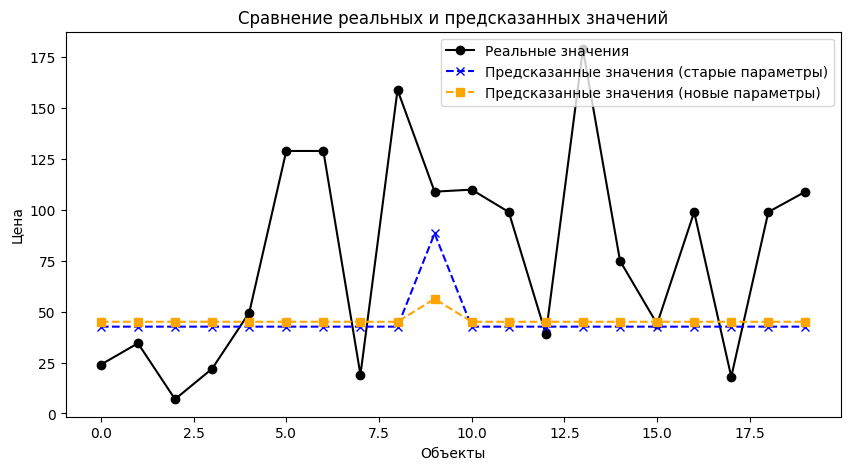

In [44]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Загрузка датасета
df = pd.read_csv("..//static//csv//jio_mart_items.csv").head(100)

# Вывод первых строк для проверки структуры
print(df.head())

# Целевая переменная
target = df['price']

# Удаление целевой переменной из признаков
features = df.drop(columns=['price', 'href'])

# Определение столбцов для обработки
num_columns = features.select_dtypes(include=['number']).columns
cat_columns = features.select_dtypes(include=['object']).columns

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline([
    ("imputer", num_imputer),
    ("scaler", num_scaler),
])

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline([
    ("imputer", cat_imputer),
    ("encoder", cat_encoder),
])

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Создание финального пайплайна
pipeline_end = Pipeline([
    ("features_preprocessing", features_preprocessing),
])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Применение пайплайна к данным
X_train_processed = pipeline_end.fit_transform(X_train)
X_test_processed = pipeline_end.transform(X_test)

# 1. Настройка параметров для старых значений
old_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Подбор гиперпараметров с помощью Grid Search для старых параметров
old_grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                               param_grid=old_param_grid,
                               scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
old_grid_search.fit(X_train_processed, y_train)

# Результаты подбора для старых параметров
old_best_params = old_grid_search.best_params_
old_best_mse = -old_grid_search.best_score_

# 2. Настройка параметров для новых значений
new_param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [10]
}

# Подбор гиперпараметров с помощью Grid Search для новых параметров
new_grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                               param_grid=new_param_grid,
                               scoring='neg_mean_squared_error', cv=2)

# Обучение модели на тренировочных данных
new_grid_search.fit(X_train_processed, y_train)

# Результаты подбора для новых параметров
new_best_params = new_grid_search.best_params_
new_best_mse = -new_grid_search.best_score_

# 5. Обучение модели с лучшими параметрами для новых значений
model_best = RandomForestRegressor(**new_best_params)
model_best.fit(X_train_processed, y_train)

# Прогнозирование на тестовой выборке
y_pred = model_best.predict(X_test_processed)

# Оценка производительности модели
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print("Старые параметры:", old_best_params)
print("Лучший результат (MSE) на старых параметрах:", old_best_mse)
print("\nНовые параметры:", new_best_params)
print("Лучший результат (MSE) на новых параметрах:", new_best_mse)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", mse)
print("Корень среднеквадратичной ошибки (RMSE) на тестовых данных:", rmse)

# Обучение модели с лучшими параметрами для старых значений
model_old = RandomForestRegressor(**old_best_params)
model_old.fit(X_train_processed, y_train)

# Прогнозирование на тестовой выборке для старых параметров
y_pred_old = model_old.predict(X_test_processed)

# Визуализация ошибок
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Реальные значения', marker='o', linestyle='-', color='black')
plt.plot(y_pred_old, label='Предсказанные значения (старые параметры)', marker='x', linestyle='--', color='blue')
plt.plot(y_pred, label='Предсказанные значения (новые параметры)', marker='s', linestyle='--', color='orange')
plt.xlabel('Объекты')
plt.ylabel('Цена')
plt.title('Сравнение реальных и предсказанных значений')
plt.legend()
plt.show()
